In [1]:
"""
Prep_multichannel_data.ipynb
Lukasz Radzinski
Charite Neurophysics Group, Berlin
Script for preprocessing multichannel
EEG recordings 
"""

'\nPrep_multichannel_data.ipynb\nLukasz Radzinski\nCharite Neurophysics Group, Berlin\nScript for preprocessing multichannel\nEEG recordings \n'

In [2]:
import os
import sys
import meet
import scipy
import tables
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy import signal as sig
import helper_scripts.helper_functions as helper_functions

# set global parameters for plots
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['savefig.dpi'] = 600

In [3]:
# select file to preprocess

filename = 'S1_EEG_comb_mc_stim'
#date = '2018-03-19'
#date = '2023-11-15'
date = '2024-06-25'
additional_plot_title = ''

filename_splitted = filename.split('_')
subject = filename_splitted[0]
measurement_type = filename_splitted[1]

if(filename_splitted[2] == 'comb'):
    combined_MEEG = True
elif(filename_splitted[2] == 'only'):
    combined_MEEG = False

if(filename_splitted[3] == 'mc'):
    multichannel = True
elif(filename_splitted[3] == 'sc'):
    multichannel = False

recording_condition = filename_splitted[4]

data_input_folder = '../Data/raw_data'
data_output_folder = '../Data/cleaned_data'
plots_output_folder = '../Results/preprocessing'

use_brown_noise = False

data_input_folder = os.path.join(data_input_folder, date, subject)
data_output_folder = os.path.join(data_output_folder, date, subject)
plots_output_folder = os.path.join(plots_output_folder, date, filename)

eeg_srate = 10000
eeg_unit = 'U [μV]'
eeg_asd_unit = '[μV/√HZ]'

if(not multichannel):
    print('Can only preprocess multichannel recordings')
    sys.exit(0)

In [4]:
# load the data

h5file_eeg = tables.open_file(os.path.join(data_input_folder, filename+'.hdf5'), mode='r', title=filename)
raw_eeg_data = np.array(h5file_eeg.root.EEG_data).T

channames = np.array(np.loadtxt('EEG_channels.txt', dtype='str'))
channames_aligned = []
for i in range(len(channames)):
    channames_aligned.append(channames[i].ljust(3))

In [5]:
# extract the signals

EEG_data = raw_eeg_data[:-1, 40:]
EEG_stimulus_data = raw_eeg_data[-1][:-40]

In [6]:
# add header to the plot function
def plt_header(main_title='', use_suptitle = False, fontsize=12):

    title = filename+', '+date
    title += '\n'+main_title+additional_plot_title

    if(use_suptitle):
        plt.suptitle(title, fontsize=fontsize)
    else:
        plt.title(title, fontsize=fontsize)

In [7]:
# show and save the plot function
def plt_show_save_fig(fig_name=None):

    if(fig_name):
        fig_name += '.png'
    else:
        plt_show_save_fig.counter += 1
        fig_name = 'Fig%02d.png' % plt_show_save_fig.counter

    print('--------------------\n'+fig_name)
    os.makedirs(plots_output_folder, exist_ok=True)
    plt.savefig(os.path.join(plots_output_folder, fig_name), bbox_inches='tight')
    plt.show()

plt_show_save_fig.counter = 0

In [8]:
# normalize signal to 0-1 range
def min_max_normalize_sig(signal):

    signal_normalized = signal - np.min(signal)
    signal_normalized /= np.max(signal_normalized)

    return signal_normalized

In [9]:
# get the stimuli positions
if(recording_condition != 'stim'):
    trial_len = int(eeg_srate/1)
    number_of_trials = int(len(EEG_data[0])/trial_len)
    all_stimuli_eeg = np.arange(number_of_trials)*trial_len
    all_stimuli_eeg = all_stimuli_eeg[1:]
else:
    # get the stimuli positions
    all_stimuli_eeg = ((EEG_stimulus_data[1:]>0.5) & (EEG_stimulus_data[:-1]<0.5)).nonzero()[0]

# get the marker, omit the first and last (avoid edge effects)
marker_eeg = all_stimuli_eeg[10:-10]

--------------------
Fig01.png


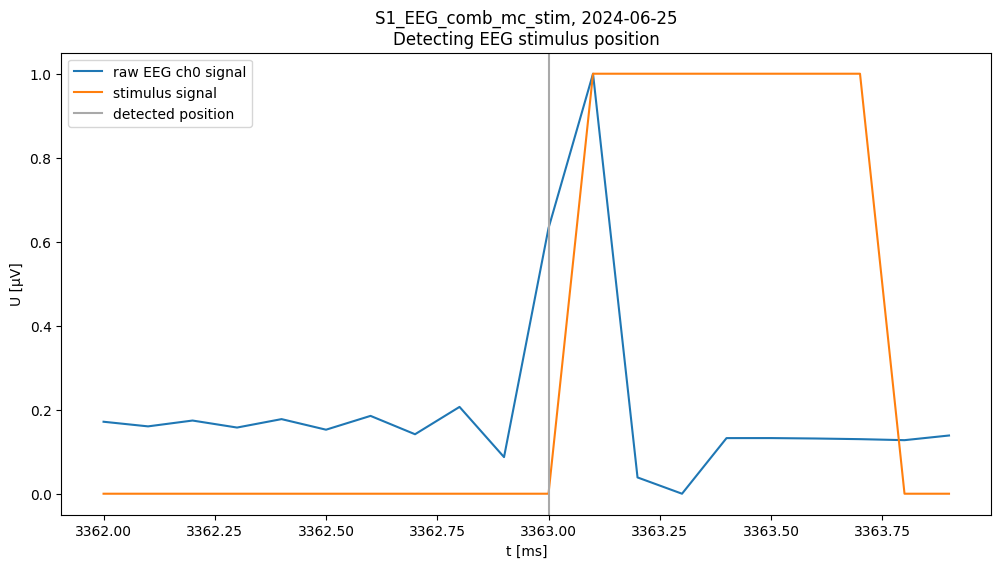

In [10]:
# plot EEG and stimulus signals

start_time = np.round(marker_eeg[0]/eeg_srate - 0.001, 5)
end_time = np.round(marker_eeg[0]/eeg_srate + 0.001, 5)

data = min_max_normalize_sig(EEG_data[0][int(start_time*eeg_srate):int(end_time*eeg_srate)])
data_x = np.linspace(start_time*1000, end_time*1000, len(data)+1)[:-1]
data_y = data
plt.plot(data_x, data_y, label='raw EEG ch0 signal')

data = min_max_normalize_sig(EEG_stimulus_data[int(start_time*eeg_srate):int(end_time*eeg_srate)])
data_x = np.linspace(start_time*1000, end_time*1000, len(data)+1)[:-1]
data_y = data
plt.plot(data_x, data_y, label='stimulus signal')

plt.axvline(1000*(marker_eeg[0])/eeg_srate, color='darkgrey', label='detected position')

plt_header('Detecting EEG stimulus position')
plt.xlabel('t [ms]')
plt.ylabel(eeg_unit)
plt.legend()
plt_show_save_fig()

In [11]:
# remove the stimuli

interpolate_win_ms_eeg = [-5, 8]
interpolate_win_eeg = np.round(np.array(interpolate_win_ms_eeg) / 1000. * eeg_srate).astype(int)
EEG_stimuli_removed_data = meet.interpolateEEG(EEG_data.copy(), all_stimuli_eeg, interpolate_win_eeg)

--------------------
Fig02.png


/tmp/ipykernel_28272/117927495.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(os.path.join(plots_output_folder, fig_name), bbox_inches='tight')
/home/lukasz-rad/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


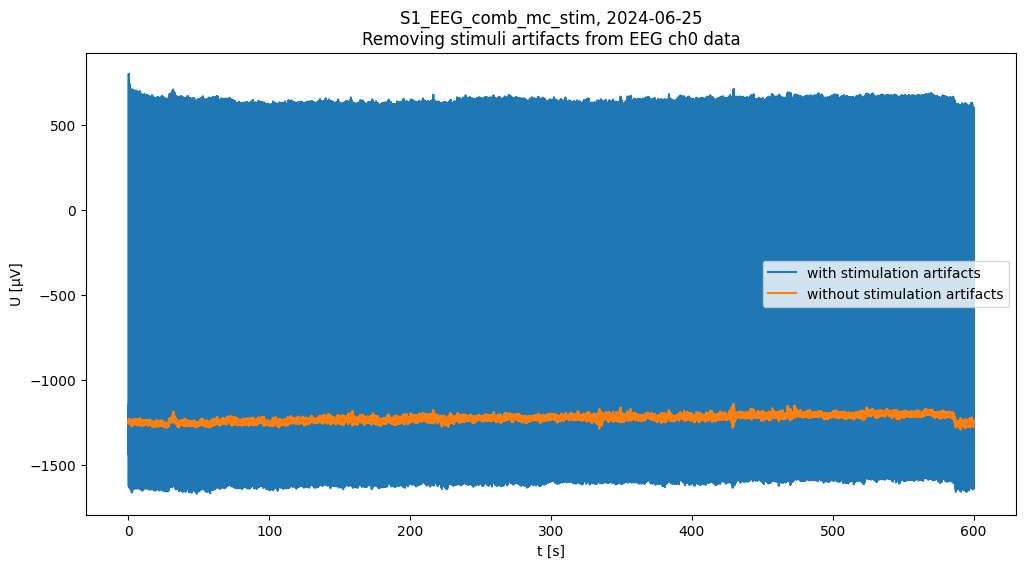

--------------------
Fig03.png


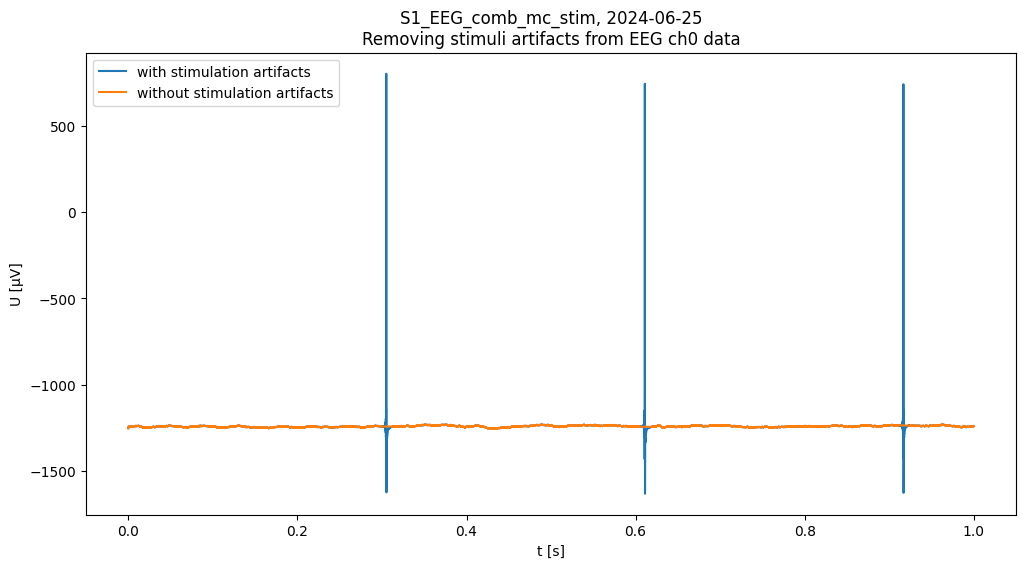

--------------------
Fig04.png


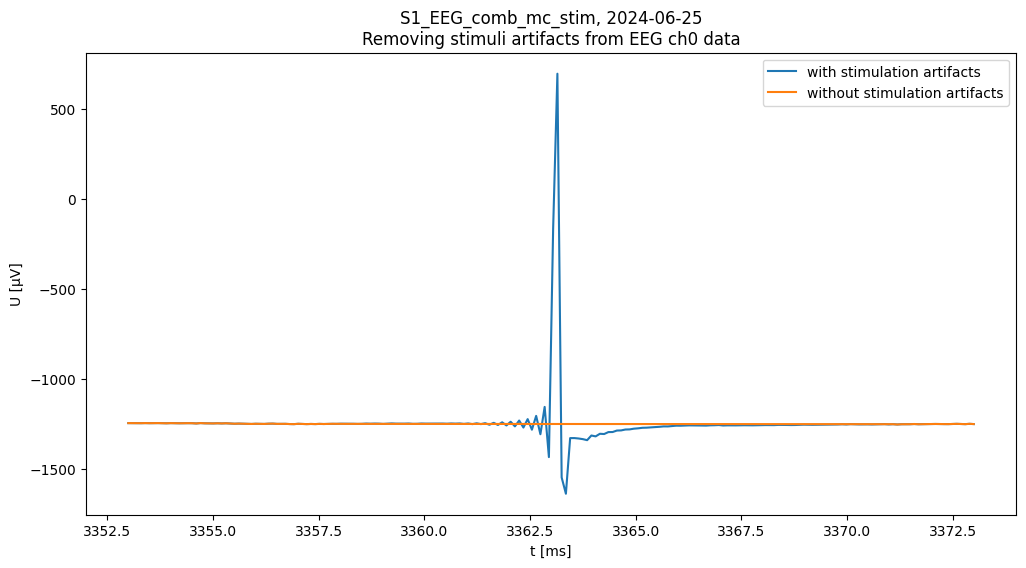

In [12]:
# plot xEG signal without stimuli

data = EEG_data[0]
data_x = np.linspace(0, (len(data)-1)/eeg_srate, len(data))
data_y = data
plt.plot(data_x, data_y, label='with stimulation artifacts')

data = EEG_stimuli_removed_data[0]
data_x = np.linspace(0, (len(data)-1)/eeg_srate, len(data))
data_y = data
plt.plot(data_x, data_y, label='without stimulation artifacts')

plt_header('Removing stimuli artifacts from EEG ch0 data')
plt.xlabel('t [s]')
plt.ylabel(eeg_unit)
plt.legend()
plt_show_save_fig()

data = EEG_data[0][:eeg_srate]
data_x = np.linspace(0, (len(data)-1)/eeg_srate, len(data))
data_y = data
plt.plot(data_x, data_y, label='with stimulation artifacts')

data = EEG_stimuli_removed_data[0][:eeg_srate]
data_x = np.linspace(0, (len(data)-1)/eeg_srate, len(data))
data_y = data
plt.plot(data_x, data_y, label='without stimulation artifacts')

plt_header('Removing stimuli artifacts from EEG ch0 data')
plt.xlabel('t [s]')
plt.ylabel(eeg_unit)
plt.legend()
plt_show_save_fig()

start_time = marker_eeg[0]/eeg_srate - 0.01 
end_time = marker_eeg[0]/eeg_srate + 0.01

data = EEG_data[0][int(start_time*eeg_srate):int(end_time*eeg_srate)]
data_x = np.linspace(start_time*1000, end_time*1000, len(data))
data_y = data
plt.plot(data_x, data_y, label='with stimulation artifacts')

data = EEG_stimuli_removed_data[0][int(start_time*eeg_srate):int(end_time*eeg_srate)]
data_x = np.linspace(start_time*1000, end_time*1000, len(data))
data_y = data
plt.plot(data_x, data_y, label='without stimulation artifacts')

plt_header('Removing stimuli artifacts from EEG ch0 data')
plt.xlabel('t [ms]')
plt.ylabel(eeg_unit)
plt.legend()
plt_show_save_fig()

In [13]:
# amplitude spectral density function
def asd(data, nfft, srate):

    yf, xf = mlab.psd(x=data, NFFT=nfft, Fs=srate, window=sig.windows.hann(nfft), noverlap=nfft//2)
    
    return xf, np.sqrt(yf)

--------------------
Fig05.png


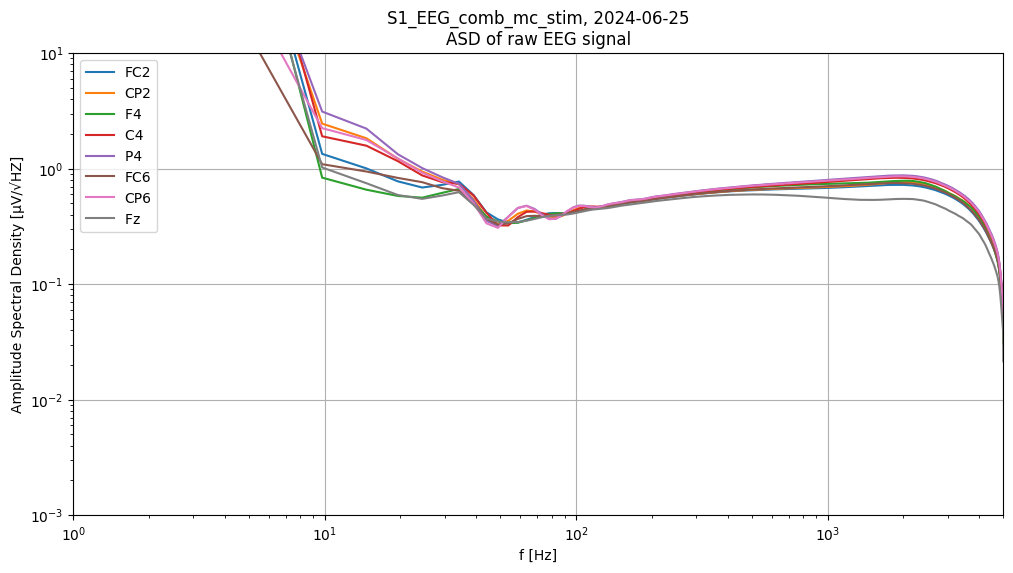

In [14]:
# calculate and plot amplitude spectral density of EEG

plt_header('ASD of raw EEG signal')

nfft = 2**(int(np.log2(eeg_srate))-2)

for i in range(len(EEG_data)):
    data = EEG_data[i]
    xf, yf = asd(data, nfft, eeg_srate)
    plt.plot(xf, yf, label=channames_aligned[i])

plt.xscale('log')
plt.yscale('log')
plt.xlim((1,eeg_srate//2))
plt.ylim((0.001, 10))
plt.xlabel('f [Hz]')
plt.ylabel('Amplitude Spectral Density %s' % eeg_asd_unit)
plt.legend()
plt.grid(True)
plt_show_save_fig()

--------------------
Fig06.png


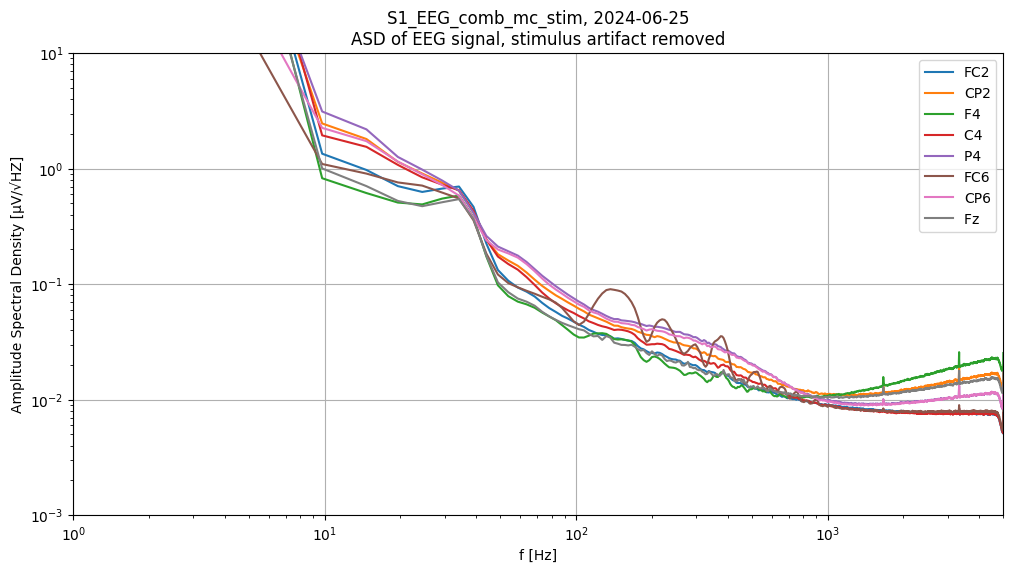

In [15]:
# calculate and plot amplitude spectral density of EEG

plt_header('ASD of EEG signal, stimulus artifact removed')

nfft = 2**(int(np.log2(eeg_srate))-2)

for i in range(len(EEG_data)):
    data = EEG_stimuli_removed_data[i]
    xf, yf = asd(data, nfft, eeg_srate)
    plt.plot(xf, yf, label=channames_aligned[i])

plt.xscale('log')
plt.yscale('log')
plt.xlim((1,eeg_srate//2))
plt.ylim((0.001, 10))
plt.xlabel('f [Hz]')
plt.ylabel('Amplitude Spectral Density %s' % eeg_asd_unit)
plt.legend()
plt.grid(True)
plt_show_save_fig()

In [16]:
# apply fc=1Hz hp filter to remove DC component
sos = sig.butter(2, 1, 'highpass', fs=eeg_srate, output='sos')
EEG_data = sig.sosfiltfilt(sos, EEG_stimuli_removed_data)

--------------------
Fig07.png


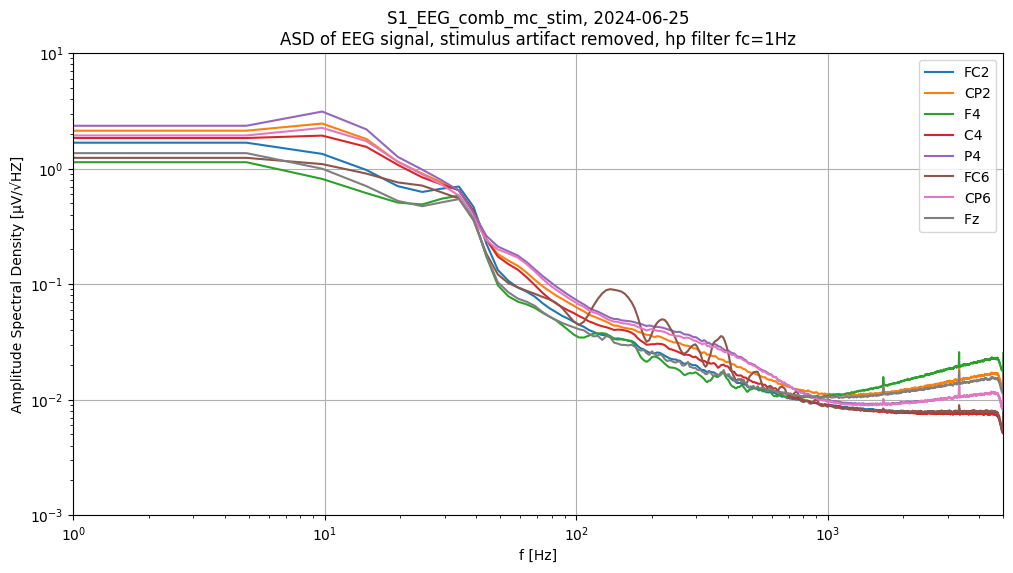

In [17]:
# calculate and plot amplitude spectral density of EEG

plt_header('ASD of EEG signal, stimulus artifact removed, hp filter fc=1Hz')

nfft = 2**(int(np.log2(eeg_srate))-2)

for i in range(len(EEG_data)):
    data = EEG_data[i]
    xf, yf = asd(data, nfft, eeg_srate)
    plt.plot(xf, yf, label=channames_aligned[i])

plt.xscale('log')
plt.yscale('log')
plt.xlim((1,eeg_srate//2))
plt.ylim((0.001, 10))
plt.xlabel('f [Hz]')
plt.ylabel('Amplitude Spectral Density %s' % eeg_asd_unit)
plt.legend()
plt.grid(True)
plt_show_save_fig()

In [18]:
# apply 450Hz-850Hz band-pass filter to extract
# high-frequency band (sigma band) and 
# high-frequency somatosensory evoked response (sigma burst)

lfreq_sigma = 450
rfreq_sigma = 850
sigma_freq_range_str = '%sHz-%sHz' % (lfreq_sigma, rfreq_sigma)

eeg_sigma_band_data = meet.iir.butterworth(EEG_data, fs=(lfreq_sigma-50, rfreq_sigma+50),
                                        fp=(lfreq_sigma, rfreq_sigma), s_rate=eeg_srate)

In [19]:
# extract EEG trials to remove outliers

whole_trial_len = int(np.round(np.mean(np.diff(all_stimuli_eeg))))
whole_trial_win_samples = [0,whole_trial_len]
whole_trial_t = (np.arange(whole_trial_win_samples[0], whole_trial_win_samples[1], 1)/float(eeg_srate)*1000)

EEG_whole_trials = meet.epochEEG(EEG_data, marker_eeg, whole_trial_win_samples)
EEG_sigma_band_whole_trials = meet.epochEEG(eeg_sigma_band_data, marker_eeg, whole_trial_win_samples)

sigma_win_ms = [10, 35]
sigma_win_samples = np.round(np.array(sigma_win_ms)/1000.*eeg_srate).astype(int)
EEG_sigma_burst_trials = meet.epochEEG(eeg_sigma_band_data, marker_eeg, sigma_win_samples)

--------------------
Fig08.png


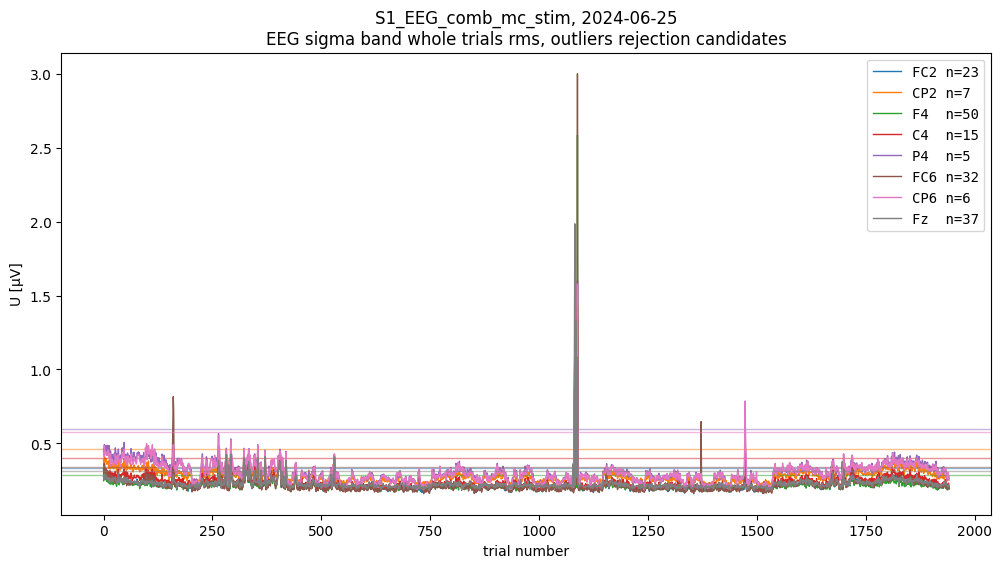

--------------------
Fig09.png


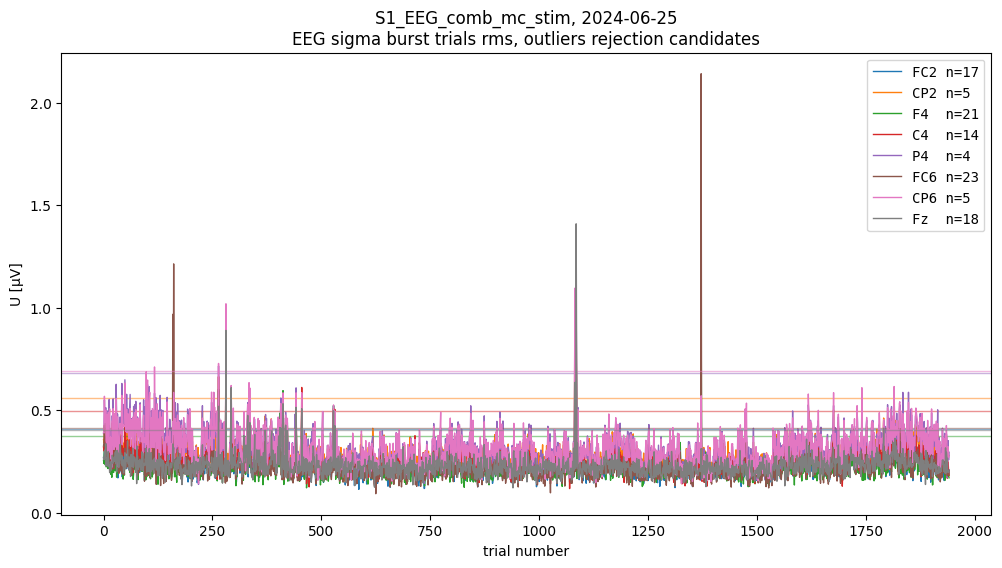

--------------------
Fig10.png


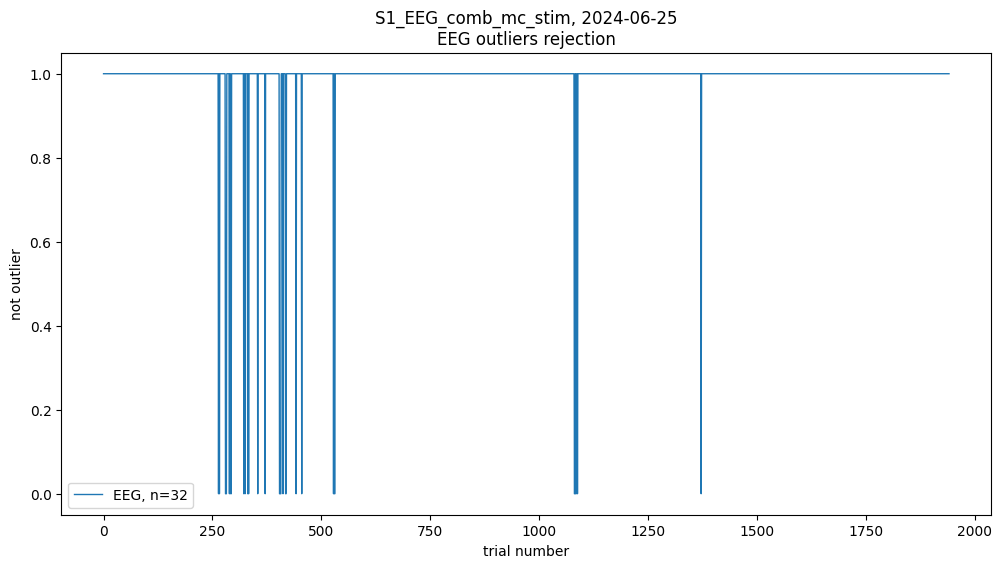

In [20]:
# calculate EEG sigma band and sigma burst trials rms and percentiles to remove outliers

not_outliers_eeg = []
thresholds_sigma_band_rms_eeg = []
thresholds_sigma_burst_rms_eeg = []

# calculate sigma band whole trials rms and percentiles to remove outliers

for i in range(len(EEG_sigma_band_whole_trials)):

    sigma_band_trials_rms = np.sqrt(np.mean(EEG_sigma_band_whole_trials[i]**2, axis=0))

    sigma_band_rms_q25 = scipy.stats.scoreatpercentile(sigma_band_trials_rms, 25)
    sigma_band_rms_q50 = np.median(sigma_band_trials_rms)
    sigma_band_rms_q75 = scipy.stats.scoreatpercentile(sigma_band_trials_rms, 75)
    sigma_band_rms_iqr = sigma_band_rms_q75 - sigma_band_rms_q25

    # set a high threshold to remove only very outliers
    threshold_sigma_band_rms = sigma_band_rms_q75 + 3*sigma_band_rms_iqr
    thresholds_sigma_band_rms_eeg.append(threshold_sigma_band_rms)
    not_outliers_sigma_band = sigma_band_trials_rms <= threshold_sigma_band_rms

    sigma_burst_trials_rms = np.sqrt(np.mean(EEG_sigma_burst_trials[i]**2, axis=0))

    sigma_burst_rms_q25 = scipy.stats.scoreatpercentile(sigma_burst_trials_rms, 25)
    sigma_burst_rms_q50 = np.median(sigma_burst_trials_rms)
    sigma_burst_rms_q75 = scipy.stats.scoreatpercentile(sigma_burst_trials_rms, 75)
    sigma_burst_iqr = sigma_burst_rms_q75 - sigma_burst_rms_q25

    # set a high threshold to remove only very outliers
    threshold_sigma_burst_rms = sigma_burst_rms_q75 + 3*sigma_burst_iqr
    thresholds_sigma_burst_rms_eeg.append(threshold_sigma_burst_rms)
    not_outliers_sigma_burst = sigma_burst_trials_rms <= threshold_sigma_burst_rms

    not_outliers_eeg.append(not_outliers_sigma_band*not_outliers_sigma_burst)

not_outliers_eeg = np.mean(not_outliers_eeg, axis=0) > 0.5

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for i in range(len(EEG_sigma_band_whole_trials)):

    data_y = np.sqrt(np.mean(EEG_sigma_band_whole_trials[i]**2, axis=0))
    outliers_threshold = thresholds_sigma_band_rms_eeg[i]
    plt.plot(np.clip(data_y, 0, 3), linewidth=1, label='%s n=%d' %
             (channames_aligned[i], np.sum(data_y > outliers_threshold)), color=colors[i])
    plt.axhline(outliers_threshold, linewidth=1, alpha=0.5, color=colors[i])

plt_header('EEG sigma band whole trials rms, outliers rejection candidates')
plt.xlabel('trial number')
plt.ylabel(eeg_unit)
plt.legend(prop={'family': 'DejaVu Sans Mono'})
plt_show_save_fig()

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for i in range(len(EEG_sigma_burst_trials)):

    data_y = np.sqrt(np.mean(EEG_sigma_burst_trials[i]**2, axis=0))
    outliers_threshold = thresholds_sigma_burst_rms_eeg[i]
    plt.plot(np.clip(data_y, 0, 3), linewidth=1, label='%s n=%d' %
             (channames_aligned[i], np.sum(data_y > outliers_threshold)), color=colors[i])
    plt.axhline(outliers_threshold, linewidth=1, alpha=0.5, color=colors[i])

plt_header('EEG sigma burst trials rms, outliers rejection candidates')
plt.xlabel('trial number')
plt.ylabel(eeg_unit)
plt.legend(prop={'family': 'DejaVu Sans Mono'})
plt_show_save_fig()

plt_header('EEG outliers rejection')
plt.plot(not_outliers_eeg, linewidth=1, label='EEG, n=%d' % np.sum(not_outliers_eeg == False))
plt.xlabel('trial number')
plt.ylabel('not outlier')
plt.legend()
plt_show_save_fig()

--------------------
Fig11.png


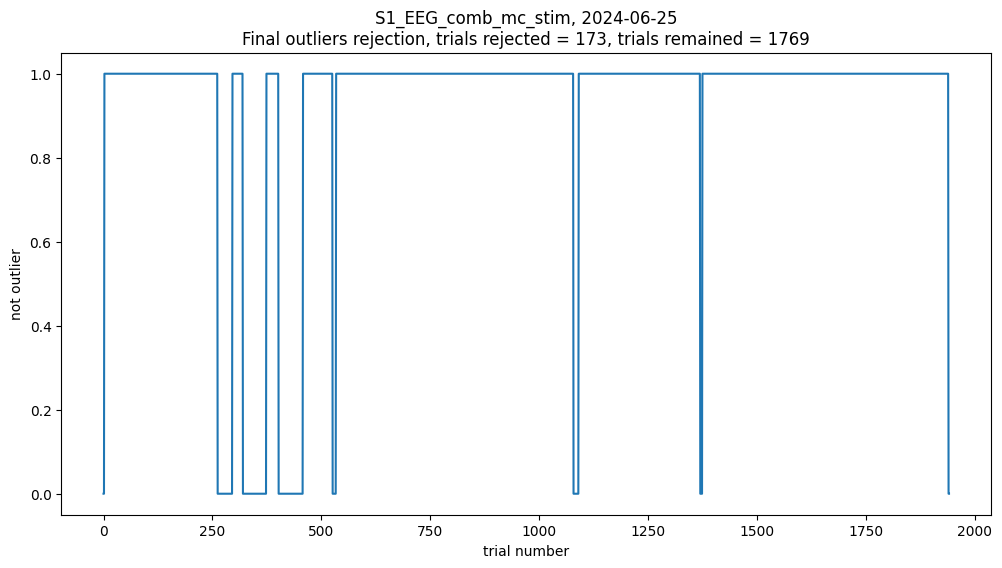

In [21]:
# final outliers estimation

not_outliers = not_outliers_eeg
not_outliers = np.convolve(not_outliers, np.ones(5)/5, mode='same')
not_outliers = (not_outliers > 0.999)

not_outliers_arr = []
temp_arr = []

last_value = False
for i in range(len(not_outliers)):
    if(not_outliers[i] == False and last_value == True):
        not_outliers_arr.append(temp_arr)
        temp_arr = []

    if(not_outliers[i] == True):
        temp_arr.append(i)
    
    last_value = not_outliers[i]

for i in range(len(not_outliers_arr)):
    if(len(not_outliers_arr[i]) < 20):
        not_outliers[not_outliers_arr[i]] = False

plt_header('Final outliers rejection, trials rejected = %d, trials remained = %d' % (np.sum(not_outliers == False), np.sum(not_outliers)))
plt.plot(not_outliers)
plt.xlabel('trial number')
plt.ylabel('not outlier')
plt_show_save_fig()

In [22]:
# reject outliers

EEG_whole_trials = EEG_whole_trials[:,:,not_outliers]
EEG_sigma_band_whole_trials = EEG_sigma_band_whole_trials[:,:,not_outliers]
EEG_sigma_burst_trials = EEG_sigma_burst_trials[:,:,not_outliers]

print(EEG_whole_trials.shape)
print(EEG_sigma_band_whole_trials.shape)
print(EEG_sigma_burst_trials.shape)

(8, 3058, 1769)
(8, 3058, 1769)
(8, 250, 1769)


In [23]:
# concatenate trials without outliers

EEG_data_no_outliers = np.concatenate(EEG_whole_trials.T).T
eeg_all_stimuli_no_outliers = (np.arange(EEG_whole_trials.shape[-1])*EEG_whole_trials.shape[-2])
eeg_marker_no_outliers = eeg_all_stimuli_no_outliers[1:]
EEG_data_no_outliers = meet.interpolateEEG(EEG_data_no_outliers, eeg_marker_no_outliers, interpolate_win_eeg)

--------------------
Fig12.png


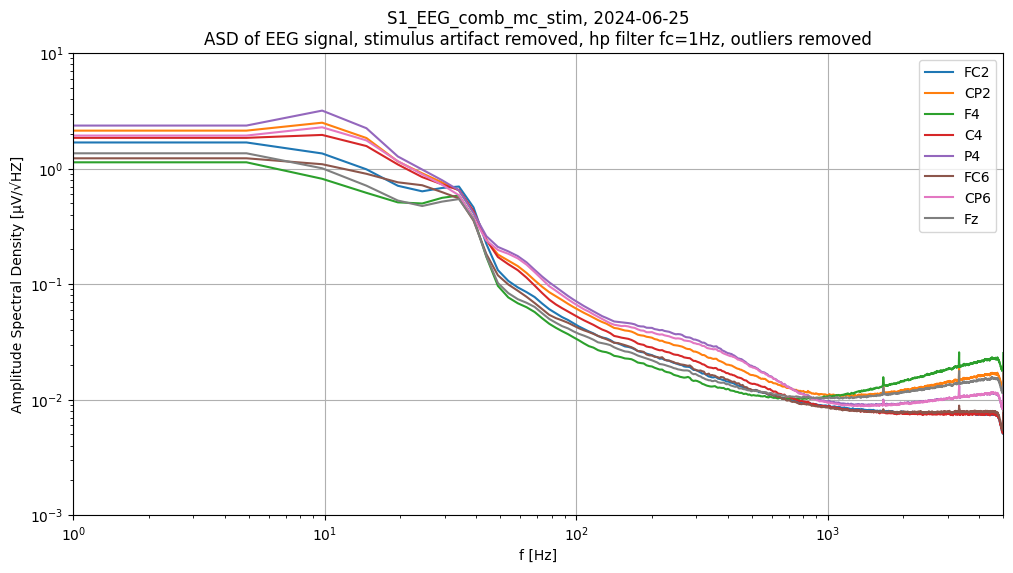

In [24]:
# plot asd of EEG data with outliers removed

plt_header('ASD of EEG signal, stimulus artifact removed, hp filter fc=1Hz, outliers removed')

nfft = 2**(int(np.log2(eeg_srate))-2)

for i in range(len(EEG_data_no_outliers)):
    data = EEG_data_no_outliers[i]
    xf, yf = asd(data, nfft, eeg_srate)
    plt.plot(xf, yf, label=channames[i])

plt.xscale('log')
plt.yscale('log')
plt.xlim((1,eeg_srate//2))
plt.ylim((0.001, 10))
plt.xlabel('f [Hz]')
plt.ylabel('Amplitude Spectral Density %s' % eeg_asd_unit)
plt.legend()
plt.grid(True)
plt_show_save_fig()

--------------------
Fig13.png


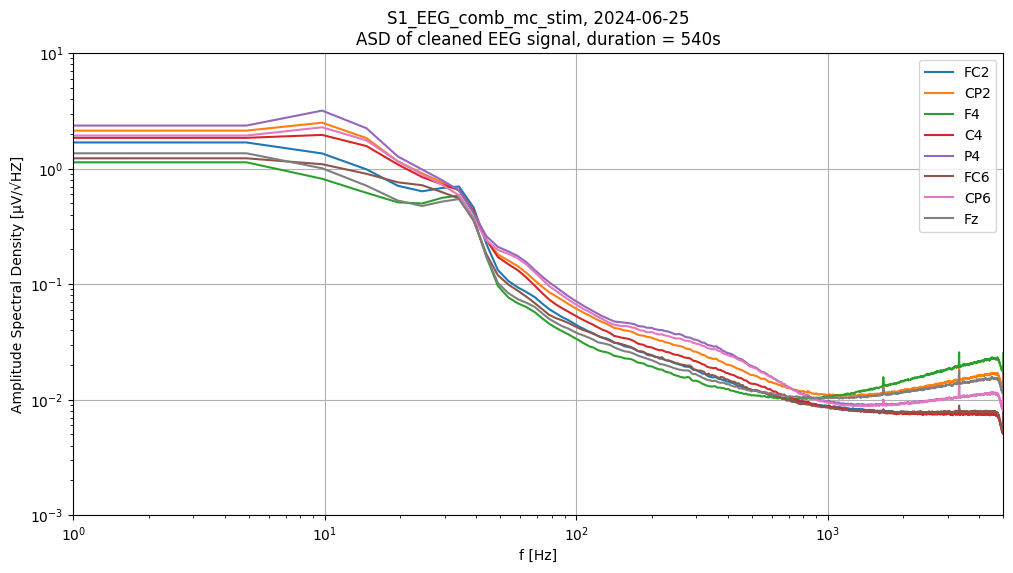

In [25]:
# plot asd of EEG data with outliers removed

plt_header('ASD of cleaned EEG signal, duration = %ds' % int(len(EEG_data_no_outliers[0])/eeg_srate))

nfft = 2**(int(np.log2(eeg_srate))-2)

for i in range(len(EEG_data_no_outliers)):
    data = EEG_data_no_outliers[i]
    xf, yf = asd(data, nfft, eeg_srate)
    plt.plot(xf, yf, label=channames[i])

plt.xscale('log')
plt.yscale('log')
plt.xlim((1,eeg_srate//2))
plt.ylim((0.001, 10))
plt.xlabel('f [Hz]')
plt.ylabel('Amplitude Spectral Density %s' % eeg_asd_unit)
plt.legend()
plt.grid(True)
plt_show_save_fig()

In [26]:
# use trials without outliers as default

EEG_data = EEG_data_no_outliers
all_stimuli_eeg = eeg_all_stimuli_no_outliers
marker_eeg = eeg_marker_no_outliers

--------------------
Fig14.png


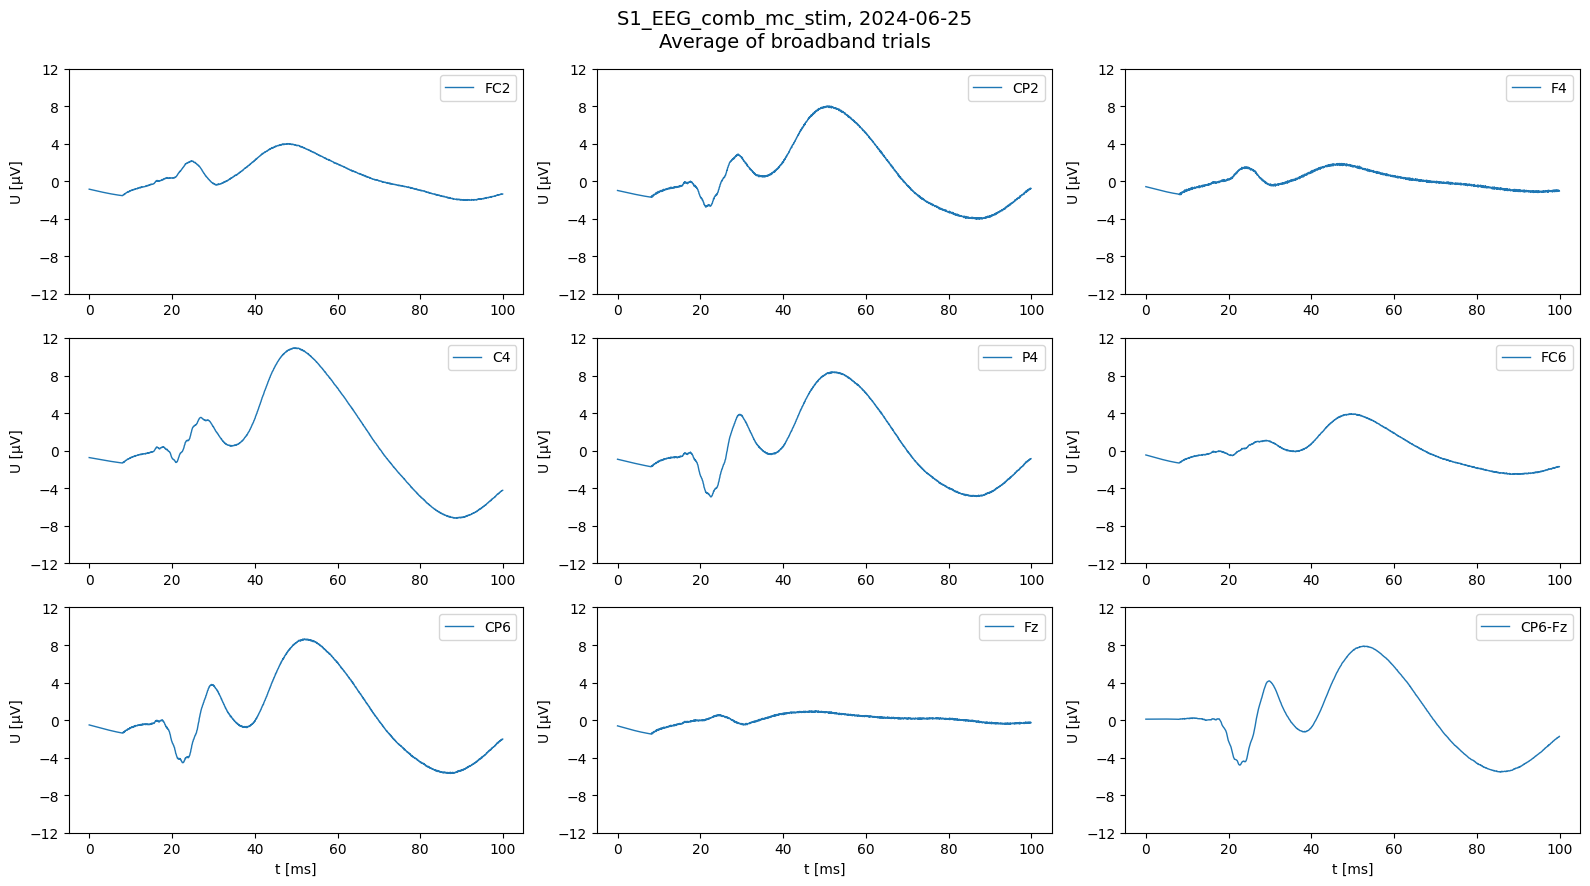

In [27]:
# plot EEG and MEG broadband evoked response

EEG_trials_averaged = np.mean(EEG_whole_trials, axis=-1)

fig, axs = plt.subplots(3, 3, figsize=(16, 9))
plt_header('Average of broadband trials', use_suptitle=True, fontsize=14)
cnt = 0
for i in range(3):
    for j in range(3):

        data_y = EEG_trials_averaged[cnt][:eeg_srate//10,]
        data_x = np.linspace(0, (len(data_y)-1)/eeg_srate, len(data_y))*1000
        axs[i][j].plot(data_x, data_y, linewidth=1, label=channames[cnt])

        #ylim = np.ceil(np.max(np.abs(EEG_trials_averaged)[:, :eeg_srate//10,]))
        ylim = 12
        axs[i][j].set_ylim((-ylim, ylim))
        axs[i][j].set_yticks((-12,-8,-4,0,4,8,12))
        axs[i][j].set_ylabel(eeg_unit)
        axs[i][j].legend()
        if(i==2):
            axs[i][j].set_xlabel('t [ms]')

        cnt+=1

        if(cnt >= 8):

            data = EEG_trials_averaged[np.array(channames)=='CP6'] - EEG_trials_averaged[np.array(channames)=='Fz']
            data_y = data[0][:eeg_srate//10,]
            data_x = np.linspace(0, (len(data_y)-1)/eeg_srate, len(data_y))*1000
            axs[2][2].plot(data_x, data_y, linewidth=1, label='CP6-Fz')

            #ylim = np.ceil(np.max(np.abs(EEG_trials_averaged)[:, :eeg_srate//10,]))
            ylim = 12
            axs[2][2].set_ylim((-ylim, ylim))
            axs[2][2].set_yticks((-12,-8,-4,0,4,8,12))

            axs[2][2].set_ylabel(eeg_unit)
            axs[2][2].legend()
            axs[2][2].set_xlabel('t [ms]')

            break


fig.tight_layout()
plt_show_save_fig()

--------------------
Fig15.png


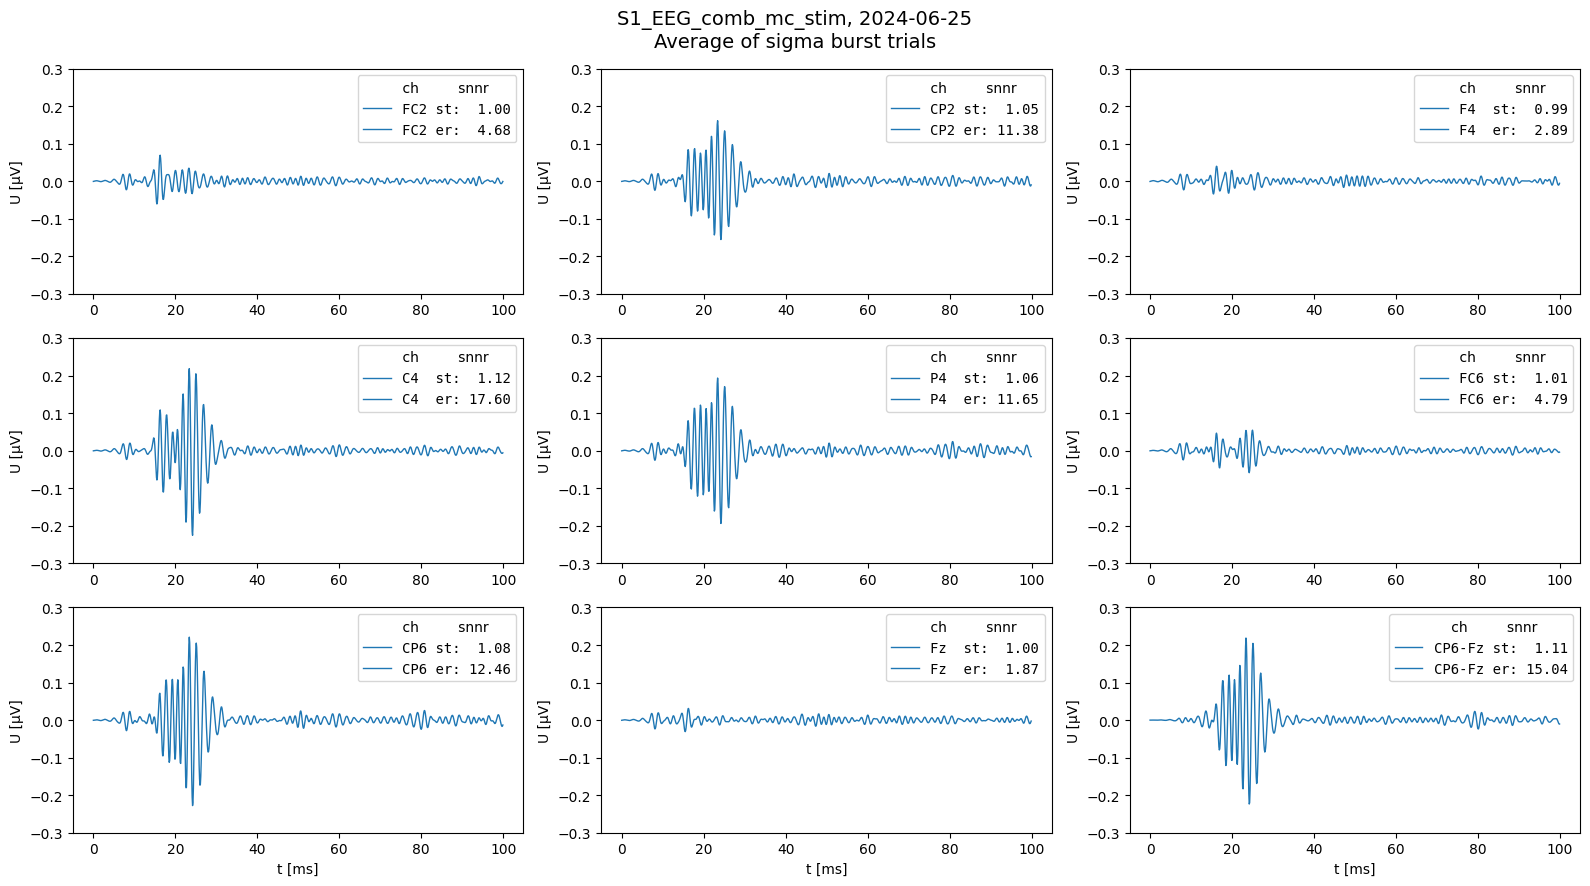

In [28]:
# plot EEG and MEG sigma burst (high-frequency somatosensory evoked response)

EEG_sigma_band_trials_averaged = np.mean(EEG_sigma_band_whole_trials, axis=-1)

fig, axs = plt.subplots(3, 3, figsize=(16, 9))
plt_header('Average of sigma burst trials', use_suptitle=True, fontsize=14)
cnt = 0
for i in range(3):
    for j in range(3):

        sigma_rms_st = np.sqrt(np.mean(EEG_sigma_band_whole_trials[cnt][(15*eeg_srate//1000):(30*eeg_srate//1000)]**2, axis=0))
        noise_rms_st = np.sqrt(np.mean(EEG_sigma_band_whole_trials[cnt][(50*eeg_srate//1000):(200*eeg_srate//1000)]**2, axis=0))
        snnr_st = np.mean(sigma_rms_st/noise_rms_st)

        sigma_rms_er = np.sqrt(np.mean(EEG_sigma_band_trials_averaged[cnt][(15*eeg_srate//1000):(30*eeg_srate//1000)]**2))
        noise_rms_er = np.sqrt(np.mean(EEG_sigma_band_trials_averaged[cnt][(50*eeg_srate//1000):(200*eeg_srate//1000)]**2))
        snnr_er = sigma_rms_er/noise_rms_er

        data_y = EEG_sigma_band_trials_averaged[cnt][:eeg_srate//10,]
        data_x = np.linspace(0, (len(data_y)-1)/eeg_srate, len(data_y))*1000

        axs[i][j].plot([], [], linewidth=1, label='%s st: %5.2f' % (channames_aligned[cnt], snnr_st), c='tab:blue')
        axs[i][j].plot(data_x, data_y, linewidth=1, label='%s er: %5.2f' % (channames_aligned[cnt], snnr_er))

        #ylim = (1+np.max(100*np.abs(EEG_sigma_band_trials_averaged)[:, :eeg_srate//10,])//5)/20
        ylim = 0.30
        axs[i][j].set_ylim((-ylim, ylim))
        axs[i][j].set_ylabel(eeg_unit)
        axs[i][j].legend(prop={'family': 'DejaVu Sans Mono'}, title='    ch         snnr')
        if(i==2):
            axs[i][j].set_xlabel('t [ms]')

        cnt+=1

        if(cnt >= 8):

            data_er = (EEG_sigma_band_trials_averaged[channames=='CP6'] - EEG_sigma_band_trials_averaged[channames=='Fz'])[0]
            sigma_rms_er = np.sqrt(np.mean(data_er[(15*eeg_srate//1000):(30*eeg_srate//1000)]**2))
            noise_rms_er = np.sqrt(np.mean(data_er[(50*eeg_srate//1000):(200*eeg_srate//1000)]**2))
            snnr_er = sigma_rms_er/noise_rms_er

            data_st = (EEG_sigma_band_whole_trials[channames=='CP6'] - EEG_sigma_band_whole_trials[channames=='Fz'])[0]
            sigma_rms_st = np.sqrt(np.mean(data_st[(15*eeg_srate//1000):(30*eeg_srate//1000)]**2, axis=0))
            noise_rms_st = np.sqrt(np.mean(data_st[(50*eeg_srate//1000):(200*eeg_srate//1000)]**2, axis=0))
            snnr_st = np.mean(sigma_rms_st/noise_rms_st)

            data_y = data_er[:eeg_srate//10,]
            data_x = np.linspace(0, (len(data_y)-1)/eeg_srate, len(data_y))*1000

            axs[2][2].plot([], [], linewidth=1, label='%s st: %5.2f' % ('CP6-Fz', snnr_st), c='tab:blue')
            axs[2][2].plot(data_x, data_y, linewidth=1, label='%s er: %5.2f' % ('CP6-Fz', snnr_er))

            #ylim = (1+np.max(100*np.abs(EEG_sigma_band_trials_averaged)[:, :eeg_srate//10,])//5)/20
            ylim = 0.30
            axs[2][2].set_ylim((-ylim, ylim))

            axs[2][2].set_ylabel(eeg_unit)
            axs[2][2].legend(prop={'family': 'DejaVu Sans Mono'}, title='      ch         snnr')
            axs[2][2].set_xlabel('t [ms]')

            break


fig.tight_layout()
plt_show_save_fig()

In [29]:
# save the preprocessed data

stimulus_eeg_new = np.zeros(EEG_data.shape[-1])
stimulus_eeg_new[marker_eeg] = 1.0
eeg_out_data = np.concatenate((EEG_data, [stimulus_eeg_new]))
os.makedirs(data_output_folder, exist_ok=True)
np.save(os.path.join(data_output_folder, filename+'.npy'), eeg_out_data)